In [1]:
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import normalize
import visdom

/home/hang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def create_dataset(num_dataset):
    #generate dataset, 4 classes
    assert num_dataset % 4 == 0
    num_each_class = int(num_dataset/4)
    means0=np.array([[1,1],[1,-1],[-1,-1],[-1,1]])
    sigma0=0.1
    X=np.random.randn(num_dataset,2)
    y=np.zeros(num_dataset).astype(int)
    for i in range(4):
        X[i*num_each_class:(i+1)*num_each_class,:]=sigma0 * X[i*num_each_class:(i+1)*num_each_class,:] + means0[i]
        y[i*num_each_class:(i+1)*num_each_class] += i
    return X,y

In [3]:
# generate data into train val and test sets
num_training = 4000
num_validation = 200
num_test = 200
X_train, y_train = create_dataset(num_training) # y_train is actually not training data, it's only used for visualization
X_val, y_val = create_dataset(num_validation)
X_test, y_test = create_dataset(num_test)

print('Traning data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Traning data shape:  (4000, 2)
Validation data shape:  (200, 2)
Test data shape:  (200, 2)


In [4]:
X_train_n=normalize(X_train,norm='max', axis=0)

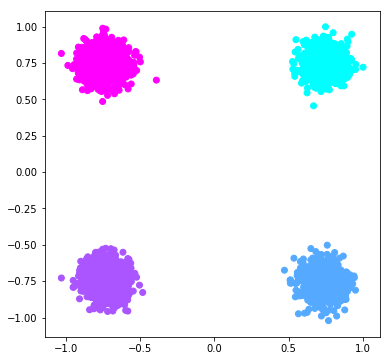

In [5]:
# visualize distribution of dataset
fig = plt.figure(figsize=1.5*plt.figaspect(1)) 
plt.scatter(X_train_n[:,0],X_train_n[:,1], c=y_train, cmap=plt.cm.cool)
plt.show()

In [6]:
# encoder neural network - take as input observation x, output mu and sigma of latent variable z and content h
class Encoder(object):
    def __init__(self,inputs,hidden_dim,z_dim,h_dim):
        self.X=inputs
        self.layer_dims=[self.X.get_shape().as_list()[1], hidden_dim, z_dim * 2 + h_dim] # output of Encoder (z_mu, z_sigma, h)
        self.nz=z_dim
        self.nh=h_dim
        with tf.variable_scope('encoder'):
            self.parameters = self._initialize_parameters()
            
    def _initialize_parameters(self):
        L=len(self.layer_dims)
        parameters={}
        for l in range(1,L-1):            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.variance_scaling_initializer(factor=0.02))
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.zeros_initializer())
        
        w_s = tf.get_variable('w_s',[self.nz,self.layer_dims[L-2]],initializer=tf.contrib.layers.variance_scaling_initializer(factor=0.02))
        w_o = tf.get_variable('w_o',[self.nz+self.nh,self.layer_dims[L-2]],initializer=tf.contrib.layers.variance_scaling_initializer())
        b_s = tf.get_variable('b_s',self.nz, initializer=tf.constant_initializer(-4))
        b_o = tf.get_variable('b_o',self.nz+self.nh, initializer=tf.constant_initializer(0))  
        parameters['W'+str(L-1)] = tf.concat([w_s,w_o],axis = 0,name='W'+str(L-1))
        parameters['b'+str(L-1)] = tf.concat([b_s,b_o],axis = 0,name='b'+str(L-1))
        return parameters
    
    def encoding(self):
        L=len(self.layer_dims)    
        A=self.X
        for l in range(1,L):
            Z = tf.add(tf.matmul(A,tf.transpose(self.parameters['W'+str(l)])),self.parameters['b'+str(l)])
            if l < (L-1):  # activation for hidden layer
                A = tf.nn.relu(Z)
#                 A = tf.nn.dropout(A,keep_prob=0.5)
            else:  # activation for output layer
                A1 = 0.001*tf.nn.softplus(Z[:,:self.nz])#sigma #when initialize, set weights values very small using factor=0.002
                A2 = Z[:,self.nz:2 * self.nz] #mu
                A3 = Z[:,2 * self.nz:] #h
               
        return A1, A2, A3

In [7]:
# decoder neural network - take as input latent variable z, output reconstructed x_hat
class Decoder(object):
    def __init__(self,inputs,hidden_dim):
        self.X=inputs
        self.nz = self.X.get_shape().as_list()[1]
        self.layer_dims = [self.nz, hidden_dim, self.nz]
        with tf.variable_scope('decoder'):
            self.parameters = self._initialize_parameters()
#             self.log_s = tf.constant(-4.6,name='sigma', shape=[1,self.nz],dtype=tf.float32) # sigma as global variable
            self.log_s = tf.get_variable('sigma',[1,self.nz],dtype=tf.float32)
    def _initialize_parameters(self):
        L=len(self.layer_dims)
        parameters={}
        for l in range(1,L):            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.variance_scaling_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.zeros_initializer())
        return parameters
    
    def decoding(self):
        L=len(self.layer_dims)    
        A=self.X
        for l in range(1,L):
            Z = tf.add(tf.matmul(A,tf.transpose(self.parameters['W'+str(l)])),self.parameters['b'+str(l)])
            if l < (L-1):  # activation for hidden layer
                A = tf.nn.relu(Z)
            else:  # activation for output layer
                A = Z               
        return A , self.log_s

In [8]:
# autoregressive neural network - take as input z_(t-1) and h, output mean and sigma of z_(t)
class AutoregNN(object):
    def __init__(self,input_z,input_h,layer_dims,idx,verbose = False):
        self.Z = input_z
        self.h = input_h
        self.z_dim = input_z.get_shape().as_list()[1]
        self.h_dim = input_h.get_shape().as_list()[1]
        self.D= self.z_dim
        self.layer_dims=layer_dims # z_dim + h_dim, arbitrary, arbitrary, z_dim + z_dim
        assert self.layer_dims[0] == self.z_dim + self.h_dim
        assert self.layer_dims[-1] == self.z_dim * 2
        self.verbose = verbose
        
        with tf.variable_scope('autoregressive_nn'+str(idx)):
            self.parameters=self._initialize_parameters()
        with tf.name_scope('autoregressive_nn'+str(idx)):
            self.mask=self.build_mask() 
        
    #initialize parameters
    def _initialize_parameters(self):
        L = len(self.layer_dims)
        parameters={}
        for l in range(1,L-1):
            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.xavier_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.constant_initializer(0.)) 
        for l in [L-1]:
            
            w_s = tf.get_variable('w_s',[self.z_dim,self.layer_dims[L-2]],initializer=tf.contrib.layers.variance_scaling_initializer())
            w_o = tf.get_variable('w_o',[self.z_dim,self.layer_dims[L-2]],initializer=tf.contrib.layers.variance_scaling_initializer())

            parameters['W' + str(l)] = tf.concat([w_s,w_o],axis = 0)            
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.constant_initializer(1)) 

    
    
        #for direct connection
        was = tf.get_variable('was',[self.z_dim,self.z_dim],initializer=tf.contrib.layers.variance_scaling_initializer())
        wam = tf.get_variable('wam',[self.z_dim,self.z_dim],initializer=tf.contrib.layers.variance_scaling_initializer())

        parameters['WA'] = tf.concat([was,wam],axis = 0)  
#         parameters['bA']=tf.get_variable('bA',self.layer_dims[L-1],initializer=tf.zeros_initializer())
        return parameters 

    # build mask    
    def single_mask(self, m_h, l, Isoutput=False):
        if l==0:
            raise ValueError('No mask for W0')        
        if Isoutput==False:
            M=np.array([[m_h[l][k]>=m_h[l-1][d] for d in range(self.layer_dims[l-1])] for k in range(self.layer_dims[l])],dtype=int)
        if Isoutput==True:
            M=np.array([[m_h[l][k]>m_h[l-1][d] for d in range(self.layer_dims[l-1])] for k in range(self.layer_dims[l])],dtype=int)
        if self.verbose:
            print('M%d:'%l + '{}'.format(M))
        return M    
    
    def build_mask(self):
        L=len(self.layer_dims)
        mask={}        
        #create mask number of each unit
        input_sel_z = np.arange(0,self.z_dim)
        input_sel_h = np.zeros(self.h_dim)-1 # a little trick to let input h be fully connected to first hidden layer 
                                    # it shouldn't have mask, but we set the mask to be True = set input_sel_h smaller than any mask number
        input_sel = np.concatenate((input_sel_z,input_sel_h))
        output_sel = np.concatenate((input_sel_z, input_sel_z))
        m_h=[input_sel]
        for l in range(1,L-1):
            m_h.append(np.random.randint(self.D-1,size=self.layer_dims[l]))
        m_h.append(output_sel)
        if self.verbose:
            print('m_h: {}'.format(m_h))
        
        for l in range(1,L-1):
            M=self.single_mask(m_h,l,Isoutput=False)
            mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
        for l in range(L-1,L):           
            M=self.single_mask(m_h,l,Isoutput=True)
            mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
    
        # for direct connection
        input_sel_direct = input_sel_z
        output_sel_direct = np.concatenate((input_sel_z, input_sel_z))
        M=np.array([[i<j for i in input_sel_direct] for j in output_sel_direct],dtype=int)
        if self.verbose:
            print('MA: {}'.format(M))
        mask['MA']=tf.constant(M,dtype=tf.float32,name='MA')                      
        
        return mask
    
    # forward compute
    def iaf(self):
        L=len(self.layer_dims)    
        A_in=tf.concat((self.Z,self.h),axis = 1)
        A = A_in
        for l in range(1,L-1):
            masked_W=np.dot(self.parameters['W'+str(l)], self.mask['M'+str(l)])
            b=self.parameters['b'+str(l)]
            Z=tf.add(tf.matmul(A,tf.transpose(masked_W)),b)
            # activation for hidden layer
            A=tf.nn.sigmoid(Z)
        for l in [L-1]:   # activation for output layer
            masked_W=np.dot(self.parameters['W'+str(l)], self.mask['M'+str(l)])
            A=tf.matmul(A,tf.transpose(masked_W))
        
        #for direct conection
        masked_W= np.dot(self.parameters['WA'], self.mask['MA'])
        A_direct=tf.matmul(self.Z,tf.transpose(masked_W))
        A = A+A_direct
        
        A = tf.add(A,self.parameters['b'+str(L-1)])
        A1 = A[:,self.z_dim:] #s
        A2 = A[:,:self.z_dim] #m

        
        return A1,A2

In [9]:
# built model
tf.reset_default_graph()
with tf.name_scope('inputs'):
    X=tf.placeholder(shape=[None,2],dtype=tf.float32)

with tf.name_scope('encoding_stage'):
    encoder=Encoder(inputs=X,hidden_dim=400,z_dim=2,h_dim=128)
    z_sigma_0,z_mu_0,h=encoder.encoding()
    epsilon = tf.random_normal(tf.shape(z_mu_0),0,1,dtype=tf.float32)
    Z = np.dot(z_sigma_0 , epsilon) + z_mu_0

with tf.name_scope('iaf_stage'):
    z_sigmas=[]
    for t in range(4):
        reverse = t>0
        if reverse:
            Z = Z[:,::-1]
        IAF = AutoregNN(input_z=Z,input_h=h,layer_dims=[130,800,800,4],idx=t)
        m,s = IAF.iaf()
        z_sigma = tf.sigmoid(s)
        Z = np.dot(z_sigma , Z) + np.dot(1 - z_sigma ,  m)
        z_sigmas.append(z_sigma)

with tf.name_scope('decoding_stage'):
    decoder=Decoder(inputs=Z,hidden_dim=400)
    x_mu_hat,x_sigma_hat = decoder.decoding()

#x_hat is only for visulization, not concerning training
with tf.name_scope('visulization_x_hat'):
    X_hat = np.dot(epsilon, x_sigma_hat) + x_mu_hat
    


Instructions for updating:
Use the retry module or similar alternatives.


In [10]:
# mini batch gradient descent
def get_mini_batch(X,y,batch_size=200):
           
    n = X.shape[0]   
    mini_batches = []
    permutation = np.random.permutation(n)
    shuffled_X = X[permutation,:] 
    shuffled_y = y[permutation]
    
    num_complete_minibatches = math.floor(n/batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * batch_size:(k + 1) * batch_size,:] 
        mini_batch_y = shuffled_y[k * batch_size:(k + 1) * batch_size]
        mini_batches.append((mini_batch_X,mini_batch_y))
    if n % batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * batch_size:,:]
        mini_batch_y = shuffled_y[num_complete_minibatches * batch_size:]
        mini_batches.append((mini_batch_X,mini_batch_y))
    
    return mini_batches 

In [11]:
a=tf.constant([1,1],dtype=tf.float32)
m=tf.constant([1,1],tf.float32)
sig=tf.constant([-12,-12],tf.float32)
log_px_=0.5*tf.reduce_sum(tf.square(a-m)/tf.exp(sig)+sig,axis=-1)
with tf.Session() as sess:
    print(sess.run(log_px_))

-12.0


In [12]:
np.exp(-4.6)

0.010051835744633586

In [13]:
# vae - iaf negative evidence lower bound - based on monte carlo sampling
def neg_elbo(X,x_mu_hat,Z):
    # log p(z_t)
    log_pz = -tf.reduce_sum(0.5*tf.log(2*math.pi) + 0.5*Z**2, axis=-1)
    # log p(x|z_t)
    log_px = 0.5*tf.reduce_sum(tf.log(2*math.pi)+tf.square(X-x_mu_hat)/tf.exp(x_sigma_hat) + x_sigma_hat,axis=-1)     
    # log q(z_t|x)
    det=np.zeros_like(z_sigmas[0])
    for item in z_sigmas:
        det+=tf.log(item)    
    log_qz = -tf.reduce_sum(0.5*tf.log(2*math.pi) + 0.5*epsilon**2 + tf.log(z_sigma_0) + det ,axis=-1)     

#     return tf.reduce_mean(log_qz-log_pz) 
#     return tf.reduce_mean(log_px)
    return tf.reduce_mean(log_px + (log_qz - log_pz))  

In [14]:
def random_data(num_dataset):
    assert num_dataset % 4 == 0
    num_each_class = int(num_dataset/4)
    means0=np.array([[1,1],[1,-1],[-1,-1],[-1,1]])
    sigma0=0.1
    X=np.random.randn(num_dataset,2)
    y=np.zeros(num_dataset).astype(int)
    for i in range(4):
        X[i*num_each_class:(i+1)*num_each_class,:]=sigma0 * X[i*num_each_class:(i+1)*num_each_class,:] + means0[i]
        y[i*num_each_class:(i+1)*num_each_class] += i
    return X,y

In [15]:
# training
def training(X_train, y_train, X_val, y_val, num_epochs = 1000, batch_size = 32, log_every=10,learning_rate = 0.003,vis_on=False, verbose = False):

    with tf.name_scope('training_loss'):
        loss = neg_elbo(X,x_mu_hat,Z)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    # training
    iterations_per_epoch = max(num_training // batch_size,1)
    counter=0
    if vis_on:

        vis = visdom.Visdom()
        mini_batch,mini_label=random_data(batch_size)
        colors = np.array([[255,255,0],[0,0,128],[0,100,0],[255,0,0]])
        old_win = vis.scatter(
            X=mini_batch,Y=mini_label+1,opts=dict(
            markersize=10,markercolor=colors,
            ),
        )
    saver=tf.train.Saver()
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        zv=sess.run(z_sigma_0,{X:X_train})
        print(np.mean(zv))
#         writer = tf.summary.FileWriter('log/new5',sess.graph)
        for epoch in range(num_epochs):            
#             mini_batch,mini_label=random_data(batch_size)
            idx=np.random.choice(num_training,batch_size)
            mini_batch = X_train[idx,:]
            mini_label=y_train[idx]+1
            counter +=1
            _,temp_cost,z_values,zv=sess.run([optimizer,loss,Z,z_sigma_0],feed_dict={X:mini_batch})
            
        
            
            if verbose and epoch % log_every ==0:
                if vis_on:
                    vis.scatter(                
                        X=z_values,Y=mini_label,
                        opts=dict(
                            markersize=10,
                            markercolor=colors,
                        ),
                        update = 'new',
                        win = old_win,
                    )   
#                 print(np.mean(sess.run(s,feed_dict={X:mini_batch})))
                
                print('%d-th train ' % (epoch) + 'cost:{} {}'.format(temp_cost,np.mean(zv)))
            if epoch%5000==0:
                saver.save(sess,file_path)
        # vizualize results x_hat and z
        mu_val,x_val,z_val=sess.run([x_mu_hat,X_hat,Z],feed_dict={X:X_train})
        fig = plt.figure(figsize=2*plt.figaspect(1))
        plt.scatter(mu_val[:,0],mu_val[:,1],c=y_train,cmap=plt.cm.cool)
        fig = plt.figure(figsize=2*plt.figaspect(1))
        plt.scatter(z_val[:,0],z_val[:,1],c=y_train,cmap=plt.cm.cool)
        plt.show()
    return None

In [19]:
training(X_train_n,y_train,X_val,y_val,num_epochs=60000, batch_size = 100, log_every = 10, verbose=True,vis_on=False)

1.8241202e-05
0-th train cost:153.19387817382812 1.823275670176372e-05
10-th train cost:27.097095489501953 2.0217019482515752e-05
20-th train cost:25.969572067260742 2.3719003365840763e-05
30-th train cost:23.53472328186035 2.9512008040910587e-05
40-th train cost:22.853557586669922 3.9170477975858375e-05
50-th train cost:21.734619140625 5.7714372815098614e-05
60-th train cost:20.60700225830078 9.490286174695939e-05
70-th train cost:19.420499801635742 0.0001831839617807418
80-th train cost:17.79942512512207 0.00036215587169863284
90-th train cost:16.109609603881836 0.0008386380504816771
100-th train cost:14.559935569763184 0.0016424215864390135
110-th train cost:13.6600341796875 0.0026092668995261192
120-th train cost:13.013866424560547 0.003606411162763834
130-th train cost:12.429102897644043 0.004583173431456089
140-th train cost:12.08492660522461 0.005505734588950872
150-th train cost:11.635610580444336 0.0063743991777300835
160-th train cost:11.388113021850586 0.007231656461954117
1

1450-th train cost:4.468235969543457 0.20461536943912506
1460-th train cost:4.619467258453369 0.20572319626808167
1470-th train cost:4.640008926391602 0.20803534984588623
1480-th train cost:4.595855236053467 0.20826564729213715
1490-th train cost:4.640626907348633 0.21127435564994812
1500-th train cost:4.511483192443848 0.21398504078388214
1510-th train cost:4.606891632080078 0.21590374410152435
1520-th train cost:4.561290264129639 0.21920464932918549
1530-th train cost:4.397101402282715 0.22208242118358612
1540-th train cost:4.473148345947266 0.2236405909061432
1550-th train cost:4.5403733253479 0.22763481736183167
1560-th train cost:4.453094005584717 0.22858215868473053
1570-th train cost:4.414590358734131 0.23083004355430603
1580-th train cost:4.496378421783447 0.23345039784908295
1590-th train cost:4.295314788818359 0.2348400503396988
1600-th train cost:4.329174041748047 0.23694583773612976
1610-th train cost:4.378962993621826 0.23873335123062134
1620-th train cost:4.18757295608520

2900-th train cost:2.8908185958862305 0.5869511961936951
2910-th train cost:2.9163262844085693 0.584641695022583
2920-th train cost:2.979076862335205 0.5802559852600098
2930-th train cost:2.831814765930176 0.591543436050415
2940-th train cost:2.8539209365844727 0.5869506597518921
2950-th train cost:2.7958431243896484 0.5901029109954834
2960-th train cost:2.8939037322998047 0.5960057973861694
2970-th train cost:2.9833405017852783 0.5955739617347717
2980-th train cost:2.8783087730407715 0.6041717529296875
2990-th train cost:2.8945822715759277 0.60526442527771
3000-th train cost:2.879498243331909 0.6020035743713379
3010-th train cost:2.8081307411193848 0.6156089901924133
3020-th train cost:2.768601655960083 0.6188743710517883
3030-th train cost:2.853055477142334 0.6205796599388123
3040-th train cost:2.736860752105713 0.6245660185813904
3050-th train cost:2.8375415802001953 0.6233386397361755
3060-th train cost:2.8250861167907715 0.625683605670929
3070-th train cost:2.8058457374572754 0.62

KeyboardInterrupt: 

In [18]:
file_path="itmw/iaf.ckpt"

INFO:tensorflow:Restoring parameters from itmw/iaf.ckpt


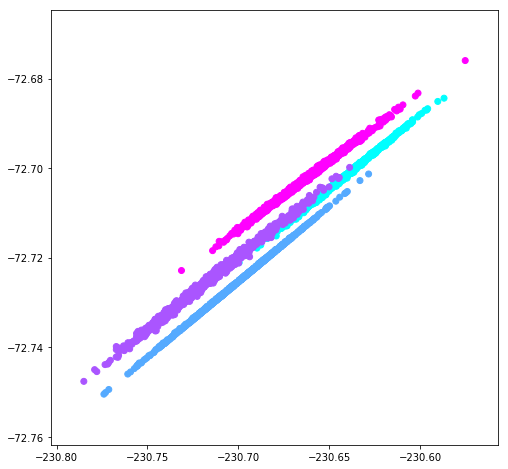

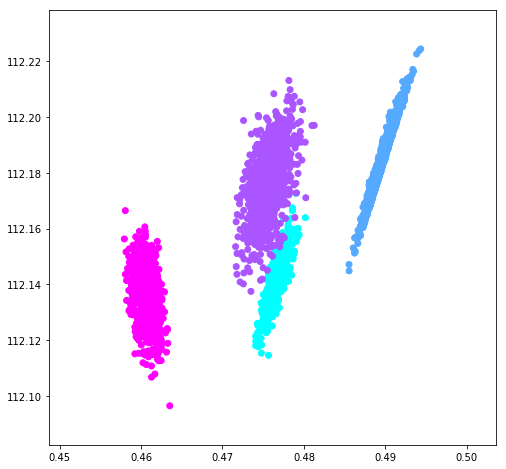

[[-0.61954296 -0.2258159 ]]


In [20]:
with tf.Session() as sess:
    saver=tf.train.Saver()
    saver.restore(sess,file_path)
    mu_val,x_val,z_val=sess.run([x_mu_hat,X_hat,Z],feed_dict={X:X_train})
    fig = plt.figure(figsize=2*plt.figaspect(1))
    plt.scatter(mu_val[:,0],mu_val[:,1],c=y_train,cmap=plt.cm.cool)
    fig = plt.figure(figsize=2*plt.figaspect(1))
    plt.scatter(z_val[:,0],z_val[:,1],c=y_train,cmap=plt.cm.cool)
    plt.show()
    print(x_sigma_hat.eval())

0-th train cost:150.66368103027344 0.997575044631958
10000-th train cost:0.30062711238861084 1.477668046951294
20000-th train cost:0.110230952501297 1.4682974815368652
30000-th train cost:-0.056605264544487 1.515908122062683
40000-th train cost:0.043118879199028015 1.4721527099609375
50000-th train cost:0.014146432280540466 1.4714131355285645
60000-th train cost:0.2615766227245331 1.487548828125
70000-th train cost:0.16450539231300354 1.4487135410308838
80000-th train cost:0.022144004702568054 1.4117847681045532
90000-th train cost:0.08288134634494781 1.4173355102539062


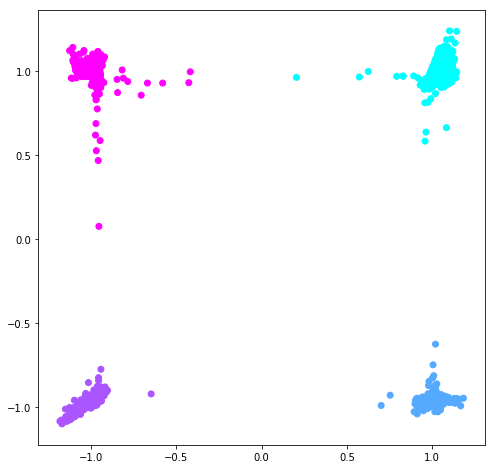

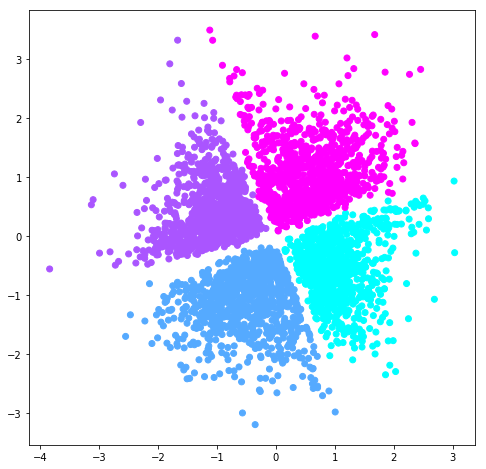

In [194]:
training(X_train,y_train,X_val,y_val,num_epochs=100000, batch_size = 128, log_every = 10000, verbose=True)

In [32]:
a=a+1#in order not to execute the next line

NameError: name 'a' is not defined

0-th train cost:9.635680198669434
500-th train cost:4.600980758666992
1000-th train cost:3.9042627811431885
1500-th train cost:3.3220832347869873
2000-th train cost:2.861252546310425
2500-th train cost:2.533806800842285
3000-th train cost:2.2574703693389893
3500-th train cost:1.8874611854553223
4000-th train cost:1.3872829675674438
4500-th train cost:0.8896805644035339
5000-th train cost:0.45872825384140015
5500-th train cost:0.07916101813316345
6000-th train cost:-0.4363865256309509
6500-th train cost:-0.7700644135475159
7000-th train cost:-0.8682286739349365
7500-th train cost:-1.0370675325393677
8000-th train cost:-0.838072657585144
8500-th train cost:-1.173579216003418
9000-th train cost:-1.3342199325561523
9500-th train cost:-0.6289161443710327
10000-th train cost:-1.681607723236084
10500-th train cost:-2.0084381103515625
11000-th train cost:-2.3349199295043945
11500-th train cost:-2.611767053604126
12000-th train cost:-2.860957622528076
12500-th train cost:-3.1499786376953125
130

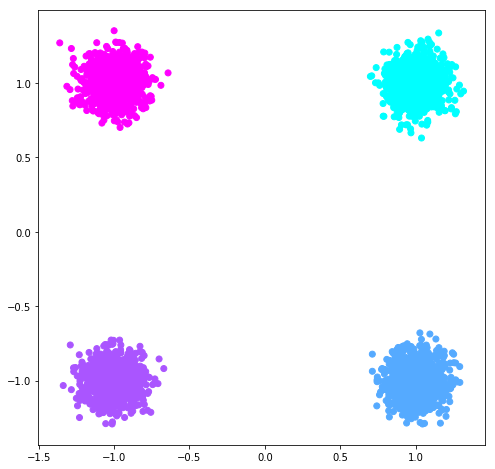

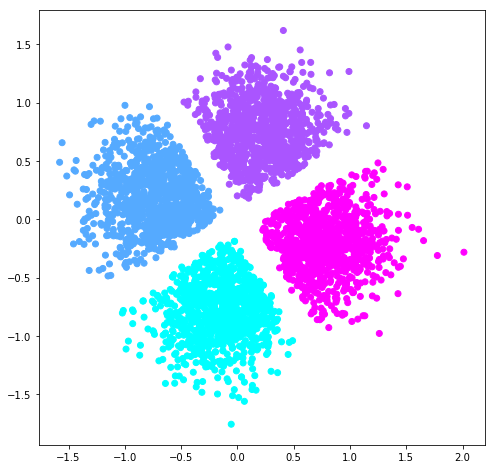

In [28]:
#training(X_train,y_train,X_val,y_val,num_epochs=100000, batch_size = 800, log_every = 500, verbose=True)